In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils as utils
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
device = torch.device('cuda')

# Prepare data

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

data_path = './drive/MyDrive/birds-classification-data/only10classes-data'

train_img_fold = ImageFolder(root=f'{data_path}/train/', transform=transform)
test_img_fold = ImageFolder(root=f'{data_path}/test/', transform=transform)
valid_img_fold = ImageFolder(root=f'{data_path}/valid/', transform=transform)

batch_size = 128
shuffle = True
num_workers = 2

train_loader = utils.data.DataLoader(train_img_fold, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_loader = utils.data.DataLoader(test_img_fold, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_loader = utils.data.DataLoader(valid_img_fold, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [ ]:
labels_dict = train_img_fold.class_to_idx
labels = [label for label in labels_dict]
print(f'Num of labels: {len(labels)}')
print(labels)

Num of labels: 10
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS']


### Example of image

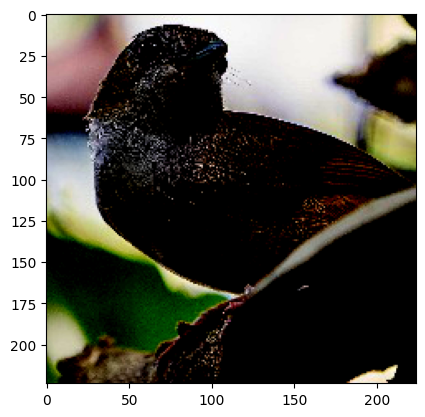

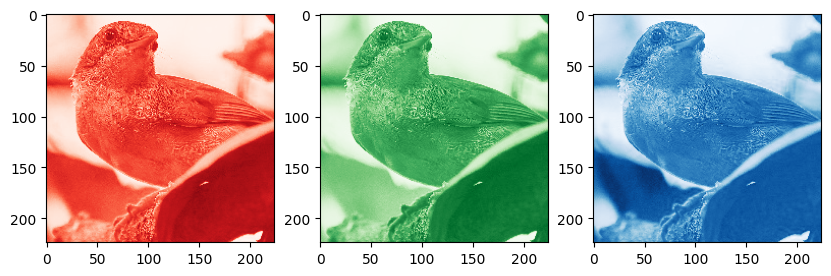

In [ ]:
example_img = train_img_fold[0][0].numpy().transpose(1, 2, 0)
plt.imshow(example_img)

fig, ax = plt.subplots(1, 3, figsize=(10, 7))

plt_cmaps = [
    plt.cm.Reds_r,
    plt.cm.Greens_r,
    plt.cm.Blues_r
]
for index, cmap in zip(range(3), plt_cmaps):
    ax[index].imshow(example_img[:, :, index], cmap=cmap)

### Example of random images from first batch of train_loader

In [ ]:
torch.manual_seed(43)

exm_dataiter = iter(train_loader)
exm_images, exm_labels = next(exm_dataiter)


In [ ]:
exm_labels

tensor([1, 5, 9, 1, 8, 8, 8, 4, 8, 7, 8, 8, 9, 6, 8, 0, 9, 3, 2, 2, 3, 2, 4, 2,
        7, 1, 4, 8, 1, 1, 3, 4, 8, 6, 5, 4, 2, 3, 7, 8, 6, 3, 7, 8, 6, 6, 5, 8,
        5, 4, 3, 9, 6, 1, 2, 7, 9, 9, 1, 6, 2, 0, 3, 9, 7, 7, 1, 5, 0, 1, 0, 4,
        9, 1, 7, 0, 3, 2, 8, 4, 8, 3, 7, 6, 8, 7, 3, 9, 7, 1, 3, 7, 1, 0, 1, 0,
        8, 4, 6, 7, 0, 7, 0, 5, 1, 6, 3, 6, 4, 8, 3, 3, 9, 5, 9, 4, 2, 8, 6, 5,
        3, 7, 4, 6, 6, 9, 9, 7])

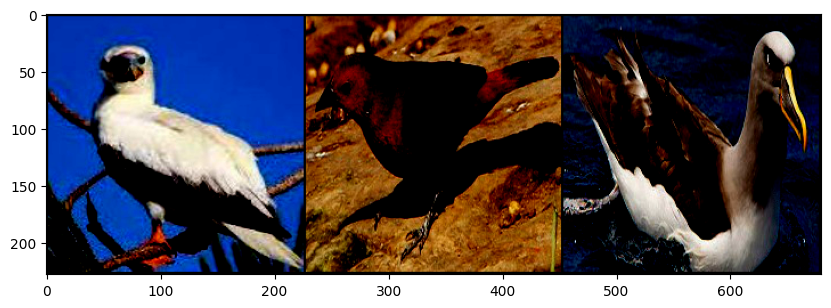

1: ABBOTTS BOOBY
2: AFRICAN FIREFINCH
3: ALBATROSS


In [ ]:
def images_grid(exm_images, num_exm=8):
    plt.figure(figsize=(10, 7))

    imgs = torchvision.utils.make_grid(exm_images[0:num_exm])
    npimg = imgs.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def names_by_index(exm_labels, labels, num_exm=8):
    for i in range(0, num_exm):
        print(f'{i+1}: {labels[exm_labels[i]]}')


num_exm = 3
images_grid(exm_images=exm_images, num_exm=num_exm)
names_by_index(exm_labels=exm_labels, labels=labels, num_exm=num_exm)

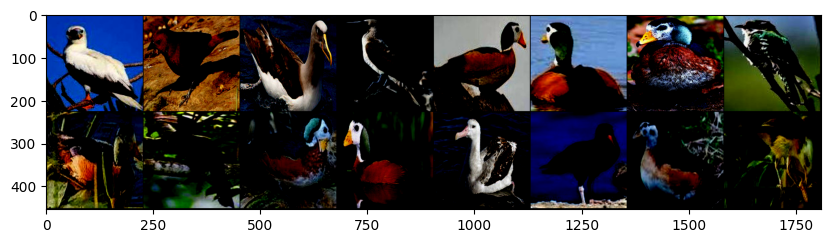

1: ABBOTTS BOOBY
2: AFRICAN FIREFINCH
3: ALBATROSS
4: ABBOTTS BOOBY
5: AFRICAN PYGMY GOOSE
6: AFRICAN PYGMY GOOSE
7: AFRICAN PYGMY GOOSE
8: AFRICAN EMERALD CUCKOO
9: AFRICAN PYGMY GOOSE
10: AFRICAN PIED HORNBILL
11: AFRICAN PYGMY GOOSE
12: AFRICAN PYGMY GOOSE
13: ALBATROSS
14: AFRICAN OYSTER CATCHER
15: AFRICAN PYGMY GOOSE
16: ABBOTTS BABBLER


In [ ]:
num_exm = 16
images_grid(exm_images=exm_images, num_exm=num_exm)
names_by_index(exm_labels=exm_labels, labels=labels, num_exm=num_exm)

# Training

### Define architectue

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_sequential = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(start_dim=1), # flatten, but keep batch (zero) dimention
            nn.Linear(26 * 26 * 512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_sequential(x)
        return x

model = Net()
model = model.to(device)

### Define optimizer and loss function

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Train

In [ ]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
torch.manual_seed(43)
train_loss_history = []

def train():

    for epoch in range(80):  # loop over the dataset multiple times
        batch_counter = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss = loss.item()

            train_loss_history.append(running_loss) ## add running loss to history

            print(f'[epoch {epoch + 1}, batch {batch_counter + 1}] Loss(CrossEntropy): {running_loss:.3f}')


            batch_counter += 1

    print('Finished Training')

train()

[epoch 1, batch 1] Loss(CrossEntropy): 2.311
[epoch 1, batch 2] Loss(CrossEntropy): 2.311
[epoch 1, batch 3] Loss(CrossEntropy): 2.307
[epoch 1, batch 4] Loss(CrossEntropy): 2.306
[epoch 1, batch 5] Loss(CrossEntropy): 2.309
[epoch 1, batch 6] Loss(CrossEntropy): 2.312
[epoch 1, batch 7] Loss(CrossEntropy): 2.310
[epoch 1, batch 8] Loss(CrossEntropy): 2.318
[epoch 1, batch 9] Loss(CrossEntropy): 2.306
[epoch 1, batch 10] Loss(CrossEntropy): 2.305
[epoch 1, batch 11] Loss(CrossEntropy): 2.306
[epoch 1, batch 12] Loss(CrossEntropy): 2.293
[epoch 1, batch 13] Loss(CrossEntropy): 2.315
[epoch 2, batch 1] Loss(CrossEntropy): 2.304
[epoch 2, batch 2] Loss(CrossEntropy): 2.308
[epoch 2, batch 3] Loss(CrossEntropy): 2.302
[epoch 2, batch 4] Loss(CrossEntropy): 2.296
[epoch 2, batch 5] Loss(CrossEntropy): 2.306
[epoch 2, batch 6] Loss(CrossEntropy): 2.292
[epoch 2, batch 7] Loss(CrossEntropy): 2.304
[epoch 2, batch 8] Loss(CrossEntropy): 2.300
[epoch 2, batch 9] Loss(CrossEntropy): 2.307
[epoch

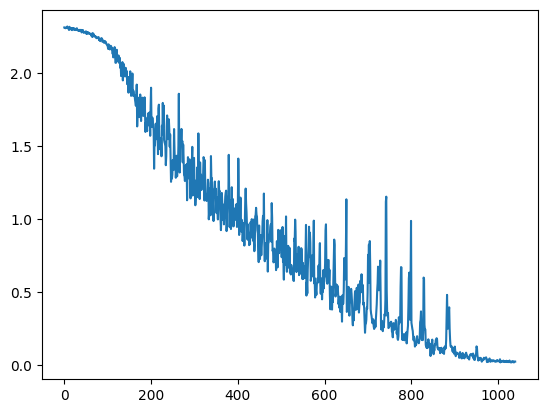

In [ ]:
plt.plot(train_loss_history)

In [ ]:
PATH = './drive/MyDrive/birds-classification-data/'

torch.save(model.state_dict(), PATH)

In [ ]:
torch.load()